# Packages

In [1]:
import numpy as np
from math import factorial as fact , sqrt as sq, exp, pi
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from scipy.stats import norm
from scipy.stats import poisson
import statistics

from scipy.special import gamma, gammaln
from hmf import MassFunction
from astropy.cosmology import Planck18
import os

from simulations import abacussummit

from scipy import interpolate

from halotools.mock_observables import tpcf
from halotools.mock_observables.pair_counters import npairs_3d
from halotools.mock_observables import return_xyz_formatted_array

# Functions 

In [2]:
simul = abacussummit()
#simul = abacuscosmos()
#simul = test_pp()
#simul = test_rand()

simname = simul.simname
direc = simul.direc
boxsize = simul.boxsize
filename = simul.filename
cutsides = simul.cutsides


'''Redshifts to be computed'''
#redshifts = ["3.000","2.000","1.100","0.500","0.200"]
redshifts = ["3.000"]
totalvolume = boxsize**3
totalbins = 50

'''Mass function from hmfcalc'''
def hmfcalc(redshift):
   print("HMF Calc") 
   global redshif
   redshif = float(redshift)
   global hmf
   hmf = MassFunction(cosmo_model=Planck18, z=redshift)
   return hmf  

#Dividing Boxes
def calcboxes (size, cutside, halo_pos):
   print("Divideing boxes: "+ str(cutside))

   nw_size = size/cutside
   x=halo_pos/nw_size
   x = x.astype(int)
   boxes = []
   for i in range (len(x)):
      boxes.append(x[i][0] + cutside*x[i][1] + cutside**2*x[i][2])
   del halo_pos
   return boxes

def nbodyhmf(halo_mass,volume):
   print("Status: Hmf")
   print("Status: Calculating height and with of mass histogarm")
   hght, binedge= np.histogram(halo_mass, bins=np.logspace(np.log10(10**10),np.log10(10**15), 101,))

   print("Status: Calculating the mass function")
   bin_centers = []
   for i in range (len(binedge)-1):
      bin_centers.append(np.sqrt(binedge[i+1]*binedge[i]))
   
   global binsize 
   binsize = []
   for i in range (len(binedge)-1):
      binsize.append(binedge[i+1]-binedge[i])
 
   hmf_hght = []
   for i in range(len(hght)):              
      hmf_hght.append(hght[i]/((binsize[i]/bin_centers[i])*volume))
   return bin_centers, hmf_hght

def gqedold (x,a,b):
   #GQED
   return (a*(1-b)/gamma(x+1) * ((a*(1-b))+(x*b))**(x-1) * np.exp(-a*(1-b)-(x*b)))

def gqed (x,a,b):
   y = a*(1-b)+(x*b)
   return np.exp(np.log(a*(1-b)) - gammaln(x+1) + (x-1)*np.log(y) - y)

def gqed_b(n_corr):
   return 1-(np.mean(n_corr)+1)**(-0.5)

def pois(x,a):
   #Poisson
   return np.exp(x*np.log(a)-a-gammaln(x+1))

def normfun(x,sig,a):
   return (1/(sig*sq(2*pi)))*np.exp(-0.5*((x-a)/sig)**2)



def f(r):
   cordata = np.logspace(-1,2, 150)
   x_points = (cordata[1:]+cordata[:-1])/2
   y_points = np.load("halocor.npy")
   
   tck = interpolate.splrep(x_points, y_points)
   return interpolate.splev(r, tck)

## Gauss Integration

In [9]:
points, weights = np.polynomial.legendre.leggauss(64)
nodes, wghts = ((points+1)/2)*(boxsize), weights*(boxsize/2)
kx, ky, kz  = np.meshgrid( nodes, nodes, nodes )
r  = np.sqrt( kx**2 + ky**2 + kz**2 )
w  = np.product( np.meshgrid(wghts,wghts,wghts), axis = 0 )
ingr = np.sum(f(r)*w)
zeta2int = ingr/(boxsize**3)

## Spherical Integration

In [1]:
from scipy.integrate import tplquad
Vtotal, _ = tplquad(lambda phi, theta, r: f(np.log10(r))*r**2 * np.sin(theta),
                0, 3*(1/3)*boxsize/2,
                lambda theta: 0, lambda theta: np.pi,
                lambda theta, phi: 0, lambda theta, phi: 2*np.pi)
Vsph, _ = tplquad(lambda phi, theta, r: f(np.log10(r))*r**2 * np.sin(theta),
                boxsize/2, 3*(1/3)*boxsize/2,
                lambda theta: 0, lambda theta: np.pi,
                lambda theta, phi: 0, lambda theta, phi: 2*np.pi)
zeta2int = Vtotal - (6*Vsph)

NameError: name 'boxsize' is not defined

# Code currently working on

## Read Data And Inialize Variables

In [3]:
for redshift in redshifts:
   print(redshift)
   directory = os.getcwd()

   pathset = os.path.join(directory,direc,redshift)
   #pathset = os.path.join(directory,direc) #for test cases without reshift

   data = np.load(os.path.join(pathset,filename) + '.npy')
   #pdf = PdfPages('Plots/'+ str(redshift) +'z ' + filename + '.pdf')
   binedge=np.logspace(np.log10(np.min(data[:,0]))-0.5,np.log10(np.max(data[:,0]))+0.5, totalbins+1)
   dm = np.log10(binedge[1])-np.log10(binedge[0])
   #Total HMF
   print("Calculating HMF")
   totalhmf = np.zeros(totalbins)
   for i in data[:,0]:
      f = int((np.log10(i) - np.log10(binedge[0]))/dm)
      totalhmf[f]= totalhmf[f]+1

   totalbin_centers = []
   for i in range (len(binedge)-1):
      totalbin_centers.append(np.sqrt(binedge[i+1]*binedge[i]))

   global binsize 
   binsize = []
   for i in range (len(binedge)-1):
      binsize.append(binedge[i+1]-binedge[i])

   totalhmf_hght = []
   for i in range(len(totalhmf)):              
      totalhmf_hght.append(totalhmf[i]/((binsize[i]/totalbin_centers[i])*totalvolume))

   #nbin_centers, nhmf_hght = nbodyhmf(data[:,0],totalvolume)

   #Total HMF from hmfcalc
   hmf = hmfcalc(redshift)

   for cutside in cutsides:
      cutside = int(cutside)
      totalboxes = cutside**3
      boxvolume = totalvolume/totalboxes
      
      boxes = calcboxes(boxsize, cutside, data[:,1:4])

      #Box halo numbers
      boxdata = np.zeros((totalbins,totalboxes))
      for i in range(len(boxes)):
         f = int((np.log10(data[:,0][i]) - np.log10(binedge[0]))/dm)
         boxdata[f][boxes[i]] = boxdata[f][boxes[i]]+1

      print('Plotting cutside:' + str(cutside))

3.000
Calculating HMF
HMF Calc
Divideing boxes: 10
Plotting cutside:10


## PLotting

Plotting cutside:10
correlation full: 0.036522603828315736
correlation: 0.33853258550448684
correlation: 0.09810319570131387
correlation: 0.06178897436679425


Text(0.05, 0.3, 'Simulation: Abaccus Summit\nCosmology: LCDM\nRedshift: 3.000\nBox Length: 500 MPc/h\n\nSub Box Length: 50.0 MPc/h\nTotal Number Of Sub Boxes: 1000\n\nNumber Of Mass Bins: 50\n\nNumber of halos: 3346751')

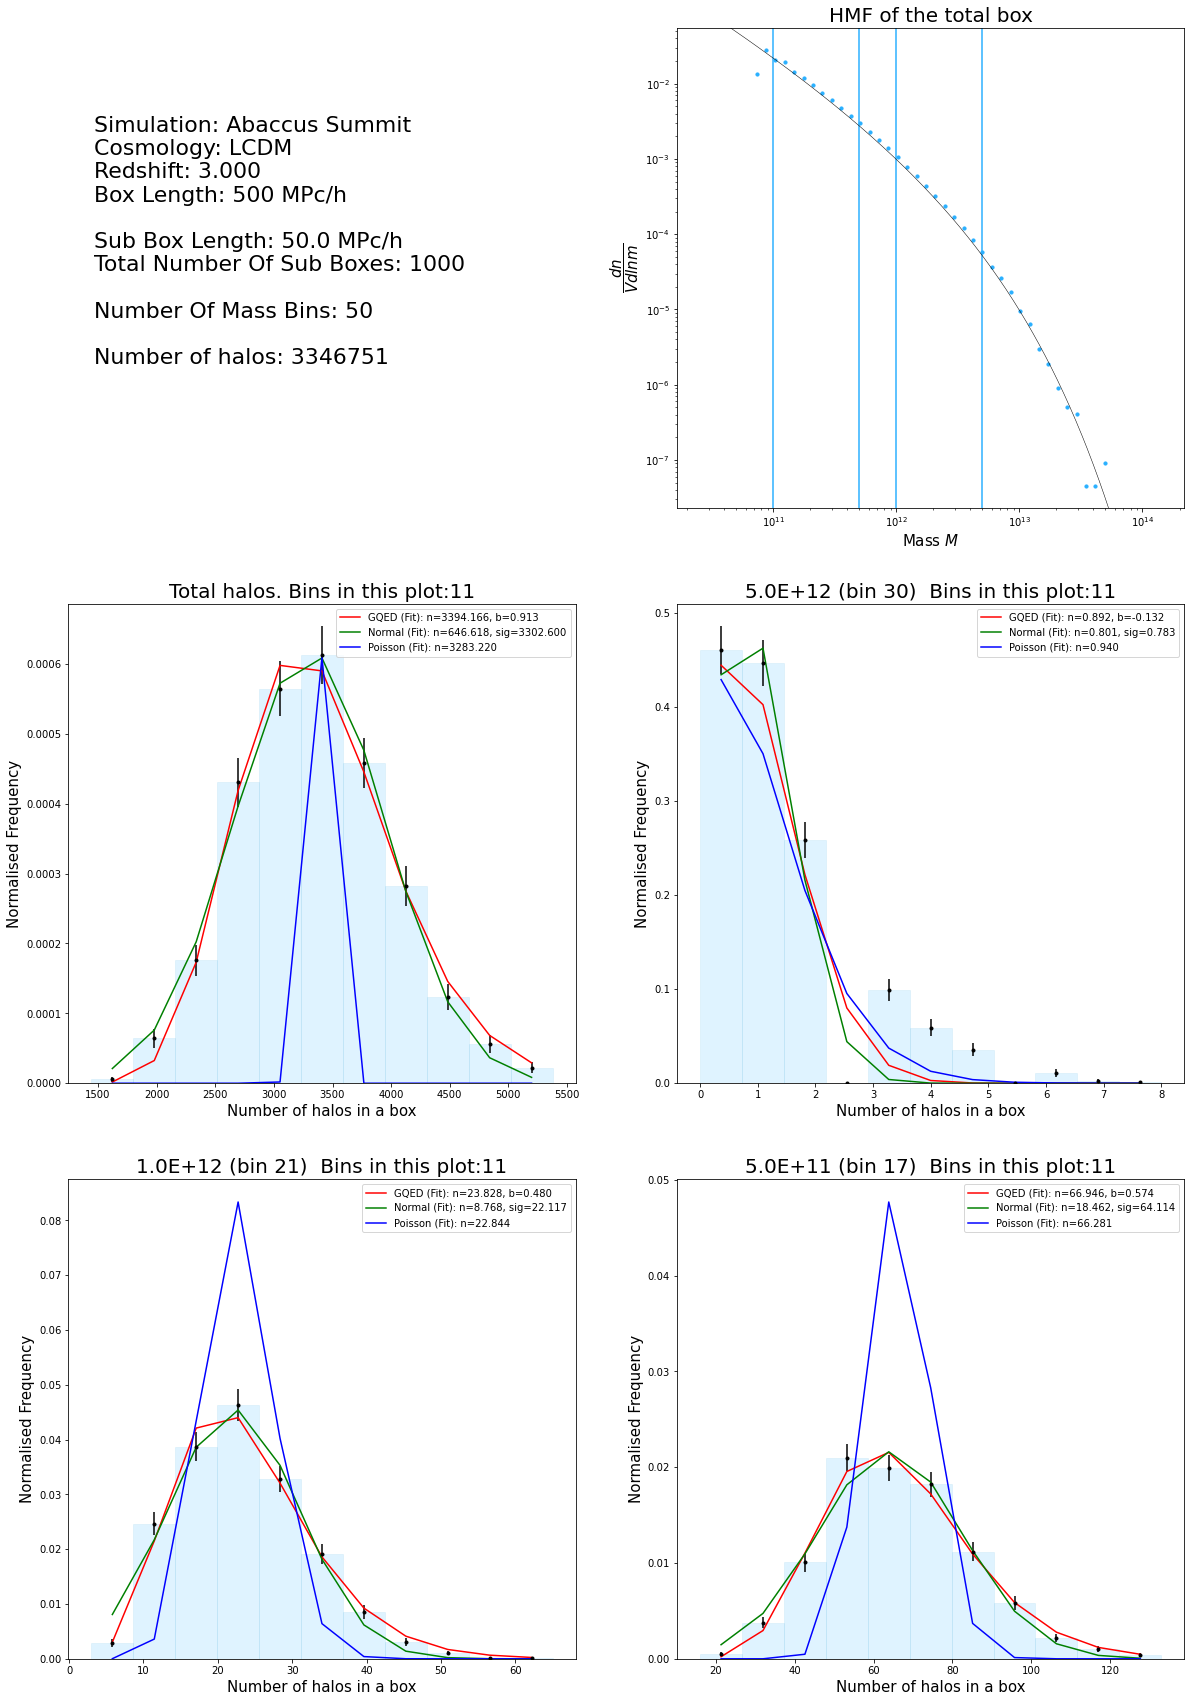

In [4]:

print('Plotting cutside:' + str(cutside))
#Plotting
fig = plt.figure(figsize=(20,30))
ax = []
ax.append(plt.subplot2grid((3,2),loc=(0,0),rowspan=1,colspan=1))
ax.append(plt.subplot2grid((3,2),loc=(0,1),rowspan=1,colspan=1))
ax.append(plt.subplot2grid((3,2),loc=(1,0),rowspan=1,colspan=1))
ax.append(plt.subplot2grid((3,2),loc=(1,1),rowspan=1,colspan=1))
ax.append(plt.subplot2grid((3,2),loc=(2,0),rowspan=1,colspan=1))
ax.append(plt.subplot2grid((3,2),loc=(2,1),rowspan=1,colspan=1))

#Plot HMF
#ax[1].scatter(nbin_centers, nhmf_hght, color = '#2ab0ff' , s=10)
ax[1].scatter(totalbin_centers, totalhmf_hght, color = '#2ab0ff' , s=10)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].axvline(x=10**11, color='#2ab0ff')
ax[1].axvline(x=5*10**11, color='#2ab0ff')
ax[1].axvline(x=10**12, color='#2ab0ff')
ax[1].axvline(x=5*10**12, color='#2ab0ff')
xmin,xmax = ax[1].get_xlim()
ymin,ymax = ax[1].get_ylim()
ax[1].loglog(hmf.m,hmf.dndlnm, linewidth=0.5, color ='k')
ax[1].set_xlim(xmin,xmax)
ax[1].set_ylim(ymin,ymax)
ax[1].set_title("HMF of the total box", fontsize=20)
ax[1].set_xlabel("Mass $M$", fontsize=15)
ax[1].set_ylabel("$\dfrac{dn}{Vdlnm}$", fontsize=15)


bins = 11

plt_ax = 2

y_valueerr, binedgeserr = np.histogram(np.sum(boxdata, axis=0), bins=bins)
y_value, binedges, patches = ax[2].hist(np.sum(boxdata, axis=0), bins=bins, density=True, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5, alpha = 0.15)
ax[plt_ax].set_title("Total halos. Bins in this plot:"+str(bins), fontsize=20)
#ax[plt_ax].set_title(f"{mass:.1E}" +" (bin " + str(f)+")  Bins in this plot:"+str(bins), fontsize=20)
ax[plt_ax].set_xlabel("Number of halos in a box", fontsize=15)
ax[plt_ax].set_ylabel("Normalised Frequency", fontsize=15)
#print(y_value)
x_value = (0.5*(binedges[1:] + binedges[:-1]))

# y_valuenew = y_valueerr/((binedges[1]-binedges[0])*np.sum(y_valueerr))

errorbar = np.sqrt(y_valueerr)/((binedges[1]-binedges[0])*np.sum(y_valueerr))
# errorbar = np.sqrt(y_value)

ax[plt_ax].errorbar(x_value, y_value, yerr=errorbar, fmt='k.')

# ax[j+3].bar(x_value, y_valuenew, 
#    yerr= errorbar, 
#    color = '#2ab0ff', edgecolor='#169acf', alpha = 0.15)


#ax[plt_ax].plot(x_value,y_value)


popt, pcov = curve_fit(gqed, x_value, y_value, p0=(np.mean(np.sum(boxdata, axis=0)),0.4))
popt2, pcov2 = curve_fit(pois, x_value, y_value, p0=(np.mean(np.sum(boxdata, axis=0)),))
popt3, pcov3 = curve_fit(normfun, x_value, y_value, p0=(np.mean(np.sum(boxdata, axis=0)),np.std(np.sum(boxdata, axis=0))))

xmin, xmax = ax[plt_ax].get_xlim()
xmin=0
x_box_no = np.arange(xmin, xmax)
x_poi_no = np.arange(xmin, xmax)
mean = np.mean(np.sum(boxdata, axis=0))
sd = np.std(np.sum(boxdata, axis=0))

ax[plt_ax].plot(x_value, gqed(x_value, *popt), 'r-', label='GQED (Fit): n=%5.3f, b=%5.3f' % tuple(popt))

var_cor_2 = (np.var(np.sum(boxdata, axis=0)) - mean)/mean**2
print("correlation full:",var_cor_2)
b_var = 1 - (mean*var_cor_2+1)**(-1/2)
# ax[plt_ax].plot(x_box_no, gqed(x_box_no, mean, b_var), 'r--', label='GQED (Varaince & Mean): n=%5.3f, b=%5.3f' % (mean,b_var))

ax[plt_ax].plot(x_value, normfun(x_value, *popt3), 'g-', label='Normal (Fit): n=%5.3f, sig=%5.3f' % tuple(popt3))
# ax[plt_ax].plot(x_box_no, norm.pdf(x_box_no, mean, sd), 'g--', label='Normal Theory: n=%5.3f, sig=%5.3f' % (mean, sd))

ax[plt_ax].plot(x_value, pois(x_value, *popt2), 'b-', label='Poisson (Fit): n=%5.3f' % tuple(popt2))
# ax[plt_ax].plot(x_poi_no, poisson.pmf(x_poi_no, mean), 'b--', label='Poisson Theory: n=%5.3f' %mean )

ax[plt_ax].legend(loc="upper right")

# x_box_no = np.arange(10, 200)
# mean, b = 155, 0.5
# ax[plt_ax].plot(x_box_no, gqed(x_box_no, mean, b), 'r--', label='GQED (Varaince & Mean): n=%5.3f, b=%5.3f' % (mean,b))
# print(gqed(x_box_no, mean, b))

masses= [5*10**12,10**12,5*10**11]
for j, mass in enumerate(masses):

   plt_ax = j+3

   f=int((np.log10(mass) - np.log10(binedge[0]))/dm)

   y_valueerr, binedgeserr = np.histogram(boxdata[f][:], bins=bins)

   y_value, binedges, _ = ax[plt_ax].hist(boxdata[f][:], bins=bins, 
      density=True, 
      facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5, alpha=0.15)
   
   x_value = (0.5*(binedges[1:] + binedges[:-1]))

   # y_valuenew = y_valueerr/((binedges[1]-binedges[0])*np.sum(y_valueerr))

   errorbar = np.sqrt(y_valueerr)/((binedges[1]-binedges[0])*np.sum(y_valueerr))
   # errorbar = np.sqrt(y_value)
   
   ax[plt_ax].errorbar(x_value, y_value, yerr=errorbar, fmt='k.')

   # ax[plt_ax].bar(x_value, y_valuenew, 
   #    yerr= errorbar, 
   #    color = '#2ab0ff', edgecolor='#169acf', alpha = 0.15)

   ax[plt_ax].set_title(f"{mass:.1E}" +" (bin " + str(f)+")  Bins in this plot:"+str(bins), fontsize=20)
   ax[plt_ax].set_xlabel("Number of halos in a box", fontsize=15)
   ax[plt_ax].set_ylabel("Normalised Frequency", fontsize=15)

   #print(y_value)
   #print(x_value)
   #ax[plt_ax].plot(x_value,y_value)
   
   popt, pcov = curve_fit(gqed, x_value, y_value, p0=(np.mean(boxdata[f][:]),0.2))
   popt2, pcov2 = curve_fit(pois, x_value, y_value, p0=(np.mean(boxdata[f][:]),))
   popt3, pcov3 = curve_fit(normfun, x_value, y_value, p0=(np.mean(boxdata[f][:]),np.std(boxdata[f][:])))

   xmin, xmax = ax[plt_ax].get_xlim()
   xmin=0
   x_box_no = np.arange(xmin, xmax)
   x_poi_no = np.arange(xmin, xmax)
   mean = np.mean(boxdata[f][:])
   sd = np.std(boxdata[f][:])

   ax[plt_ax].plot(x_value, gqed(x_value, *popt), 'r-', label='GQED (Fit): n=%5.3f, b=%5.3f' % tuple(popt))

   var_cor_2 = (np.var(boxdata[f][:]) - mean)/mean**2
   print("correlation:",var_cor_2)
   b_var = 1 - (mean*var_cor_2+1)**(-1/2)
   # ax[plt_ax].plot(x_box_no, gqed(x_box_no, mean, b_var), 'r--', label='GQED (Varaince & Mean): n=%5.3f, b=%5.3f' % (mean,b_var))

   # b_int = 1 - (mean*zeta2int+1)**(-1/2)
   # ax[plt_ax].plot(x_box_no, gqed(x_box_no, mean, b_int), 'r--', label='GQED (Integral): n=%5.3f, b=%5.3f' % (mean,b_int))

   ax[plt_ax].plot(x_value, normfun(x_value, *popt3), 'g-', label='Normal (Fit): n=%5.3f, sig=%5.3f' % tuple(popt3))
   # ax[plt_ax].plot(x_box_no, norm.pdf(x_box_no, mean, sd), 'g--', label='Normal (Theory): n=%5.3f, sig=%5.3f' % (mean, sd))

   ax[plt_ax].plot(x_value, pois(x_value, *popt2), 'b-', label='Poisson (Fit): n=%5.3f' % tuple(popt2))
   # ax[plt_ax].plot(x_box_no, poisson.pmf(x_poi_no, mean), 'b--', label='Poisson Theory: n=%5.3f' %mean )

   ax[plt_ax].legend(loc="upper right")



ax[0].axis('off')
ax[0].text(0.05, 0.3, 'Simulation: ' + str(simname) +
                     '\nCosmology: LCDM' +
                     '\nRedshift: ' + str(redshift) + 
                     '\nBox Length: ' + str(boxsize) + ' MPc/h' +
                     '\n\nSub Box Length: ' + str(boxsize/cutside) + ' MPc/h' +
                     '\nTotal Number Of Sub Boxes: ' + str(totalboxes) +
                     '\n\nNumber Of Mass Bins: ' + str(totalbins) +
                     '\n\nNumber of halos: ' + str(len(data[:,0]))
                     ,size=22)

# plt.savefig(filename + str(size/cutside) + ".pdf")
# del data, boxdata, totalbin_centers, totalhmf_hght
# pdf.close()

## Correlation Calculator

In [15]:

x_data=np.array(data[:,1])
y_data=np.array(data[:,2])
z_data=np.array(data[:,3])

pos_data=return_xyz_formatted_array(x_data, y_data, z_data)
print(pos_data)
rbins = np.logspace(-1,2, 150)
print(len(pos_data))
#rbin_centers = (rbins[1:] + rbins[:-1])/2
rbin_centers =np.sqrt(rbins[1:] * rbins[:-1])
halocorelation=tpcf(pos_data,rbins, period=boxsize,estimator='Natural')





[[1.19650269e+00 1.15310669e+00 3.49649048e+00]
 [4.98672485e-01 1.22955322e-01 4.71563416e+01]
 [4.51080322e-01 9.74334717e-01 4.87352448e+01]
 ...
 [4.99376282e+02 4.99853790e+02 4.06362518e+02]
 [4.99337006e+02 4.99186737e+02 4.06480377e+02]
 [4.99477966e+02 4.99497223e+02 4.35792786e+02]]
3346751


In [80]:
from scipy.stats import poisson

x = np.arange(0,100, 3)
#y = poisson.pmf(x, mu=50)
fig = plt.figure(figsize=(10,15))
ax = []
ax.append(plt.subplot2grid((1,3),loc=(0,0),rowspan=1,colspan=1))
ax.append(plt.subplot2grid((1,3),loc=(0,1),rowspan=1,colspan=1))
ax.append(plt.subplot2grid((1,3),loc=(0,2),rowspan=1,colspan=1))

# popt, pcov = curve_fit(gqed, x, y, p0=(20,0.4))
# popt2, pcov2 = curve_fit(pois, x, y, p0=(20,))

ax[0].plot(x, gqed(x, ), 'r-', label='GQED')
ax[1].plot(x, pois(x, *popt2), 'b-', label='Poisson')

print(popt)


ax[0].scatter(x,y)
ax[0].legend(loc="upper right")



# Test Code with 1 plot

3.000
Divideing boxes: 10
Plotting cutside:10


/tmp/ipykernel_8766/341163171.py:63: RuntimeWarning: overflow encountered in power
  return ((a*(1-b))/gamma(x+1)) * (a*(1-b)+x*b)**(x-1) * np.exp(-a*(1-b)-(x*b))
/tmp/ipykernel_8766/341163171.py:63: RuntimeWarning: invalid value encountered in multiply
  return ((a*(1-b))/gamma(x+1)) * (a*(1-b)+x*b)**(x-1) * np.exp(-a*(1-b)-(x*b))
/home/albinpjames/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


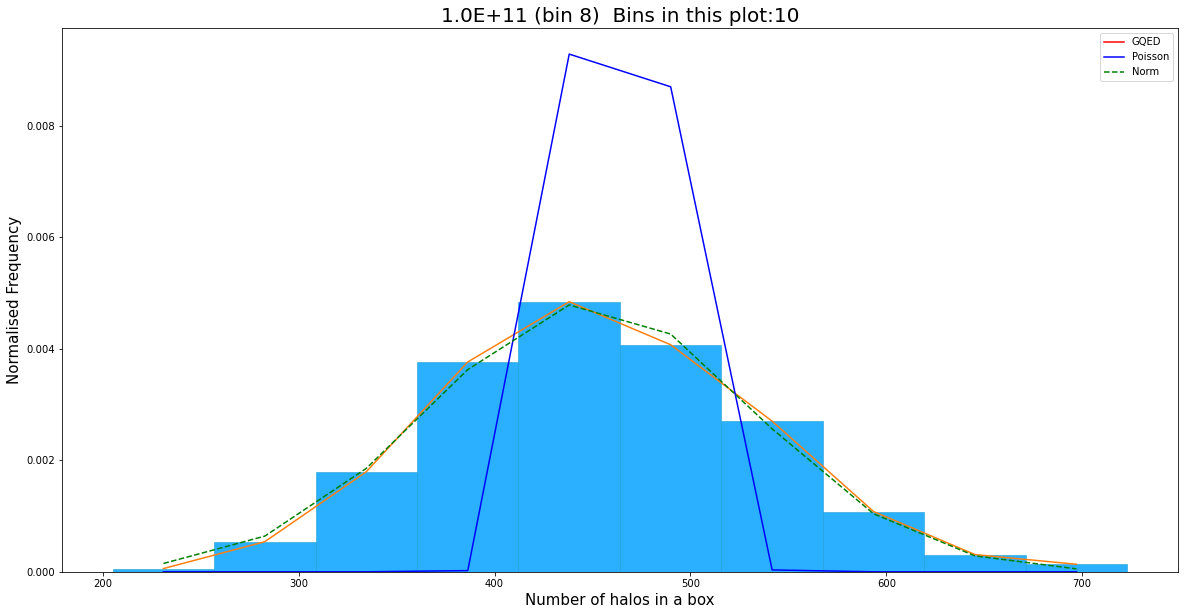

In [34]:
for redshift in redshifts:
   print(redshift)
   directory = os.getcwd()

   pathset = os.path.join(directory,direc,redshift)
   #pathset = os.path.join(directory,direc) #for test cases without reshift

   data = np.load(os.path.join(pathset,filename) + '.npy')
   #pdf = PdfPages('Plots/'+ str(redshift) +'z ' + filename + '.pdf')
   binedge=np.logspace(np.log10(np.min(data[:,0]))-0.5,np.log10(np.max(data[:,0]))+0.5, totalbins+1)
   dm = np.log10(binedge[1])-np.log10(binedge[0])
   #Total HMF
   
   for cutside in cutsides:
      cutside = int(cutside)
      totalboxes = cutside**3
      boxvolume = totalvolume/totalboxes
      
      boxes = calcboxes(boxsize, cutside, data[:,1:4])

      #Box halo numbers
      boxdata = np.zeros((totalbins,totalboxes))
      for i in range(len(boxes)):
         f = int((np.log10(data[:,0][i]) - np.log10(binedge[0]))/dm)
         boxdata[f][boxes[i]] = boxdata[f][boxes[i]]+1

      print('Plotting cutside:' + str(cutside))
      #Plotting
      fig = plt.figure(figsize=(20,10))
      ax = []
      ax.append(plt.subplot2grid((1,1),loc=(0,0),rowspan=1,colspan=1))

      bins =10
      #masses= [10**11,10**12,5*10**12]
      masses= [10**11]
      for j, mass in enumerate(masses):

         f=int((np.log10(mass) - np.log10(binedge[0]))/dm)
         y_value, binedges, patches =  ax[j].hist(boxdata[f][:], bins=bins, density= True, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
         ax[j].set_title(f"{mass:.1E}" +" (bin " + str(f)+")  Bins in this plot:"+str(bins), fontsize=20)
         ax[j].set_xlabel("Number of halos in a box", fontsize=15)
         ax[j].set_ylabel("Normalised Frequency", fontsize=15)

         #print(y_value)
         x_value = (0.5*(binedges[1:] + binedges[:-1]))
         #print(x_value)
         
        
         ax[j].plot(x_value,y_value)
         
         mean = np.mean(boxdata[f][:])
         popt, pcov = curve_fit(gqed, x_value, y_value, p0=(mean,0.4))
         popt2, pcov2 = curve_fit(pois, x_value, y_value, p0=(mean,))
         popt3, pcov3 = curve_fit(norm, x_value, y_value, p0=(mean,np.std(boxdata[f][:])))
      
         ax[j].plot(x_value, gqed(x_value, *popt), 'r-', label='GQED')
         ax[j].plot(x_value, pois(x_value, *popt2), 'b-', label='Poisson')
         ax[j].plot(x_value, norm(x_value, *popt3), 'g--', label='Norm')

         
         #label='fit: n=%5.3f, b=%5.3f' % tuple(popt))

         # xmin, xmax = ax[j].get_xlim()
         # xmin=0
         # x_box_no = np.arange(xmin, xmax, 0.01)
         # x_poi_no = np.arange(xmin, xmax)
         # mean = np.mean(boxdata[f][:])
         # sd = np.std(boxdata[f][:])
         # ax[j].plot(x_box_no, norm.pdf(x_box_no, mean, sd), 'k--', label='Gaussian')
         # ax[j].plot(x_poi_no, poisson.pmf(x_poi_no, mean), 'k', label='Poisson' )
         ax[j].legend(loc="upper right")
   


      #plt.savefig(filename + str(size/cutside) + ".pdf")
   #del data, boxdata, totalbin_centers, totalhmf_hght
   del data, boxdata
   #pdf.close()

# CIC With Fit & Theory

3.000
Calculating HMF
HMF Calc
Divideing boxes: 10
Plotting cutside:10
Plotting cutside:10


/tmp/ipykernel_11739/932204459.py:63: RuntimeWarning: overflow encountered in power
  return ((a*(1-b))/gamma(x+1)) * (a*(1-b)+x*b)**(x-1) * np.exp(-a*(1-b)-(x*b))
/home/albinpjames/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_11739/932204459.py:63: RuntimeWarning: overflow encountered in power
  return ((a*(1-b))/gamma(x+1)) * (a*(1-b)+x*b)**(x-1) * np.exp(-a*(1-b)-(x*b))
/tmp/ipykernel_11739/932204459.py:63: RuntimeWarning: overflow encountered in power
  return ((a*(1-b))/gamma(x+1)) * (a*(1-b)+x*b)**(x-1) * np.exp(-a*(1-b)-(x*b))


Text(0.05, 0.3, 'Simulation: Abaccus Summit\nCosmology: LCDM\nRedshift: 3.000\nBox Length: 500 MPc/h\n\nSub Box Length: 50.0 MPc/h\nTotal Number Of Sub Boxes: 1000\n\nNumber Of Mass Bins: 50\n\nNumber of halos: 3346751')

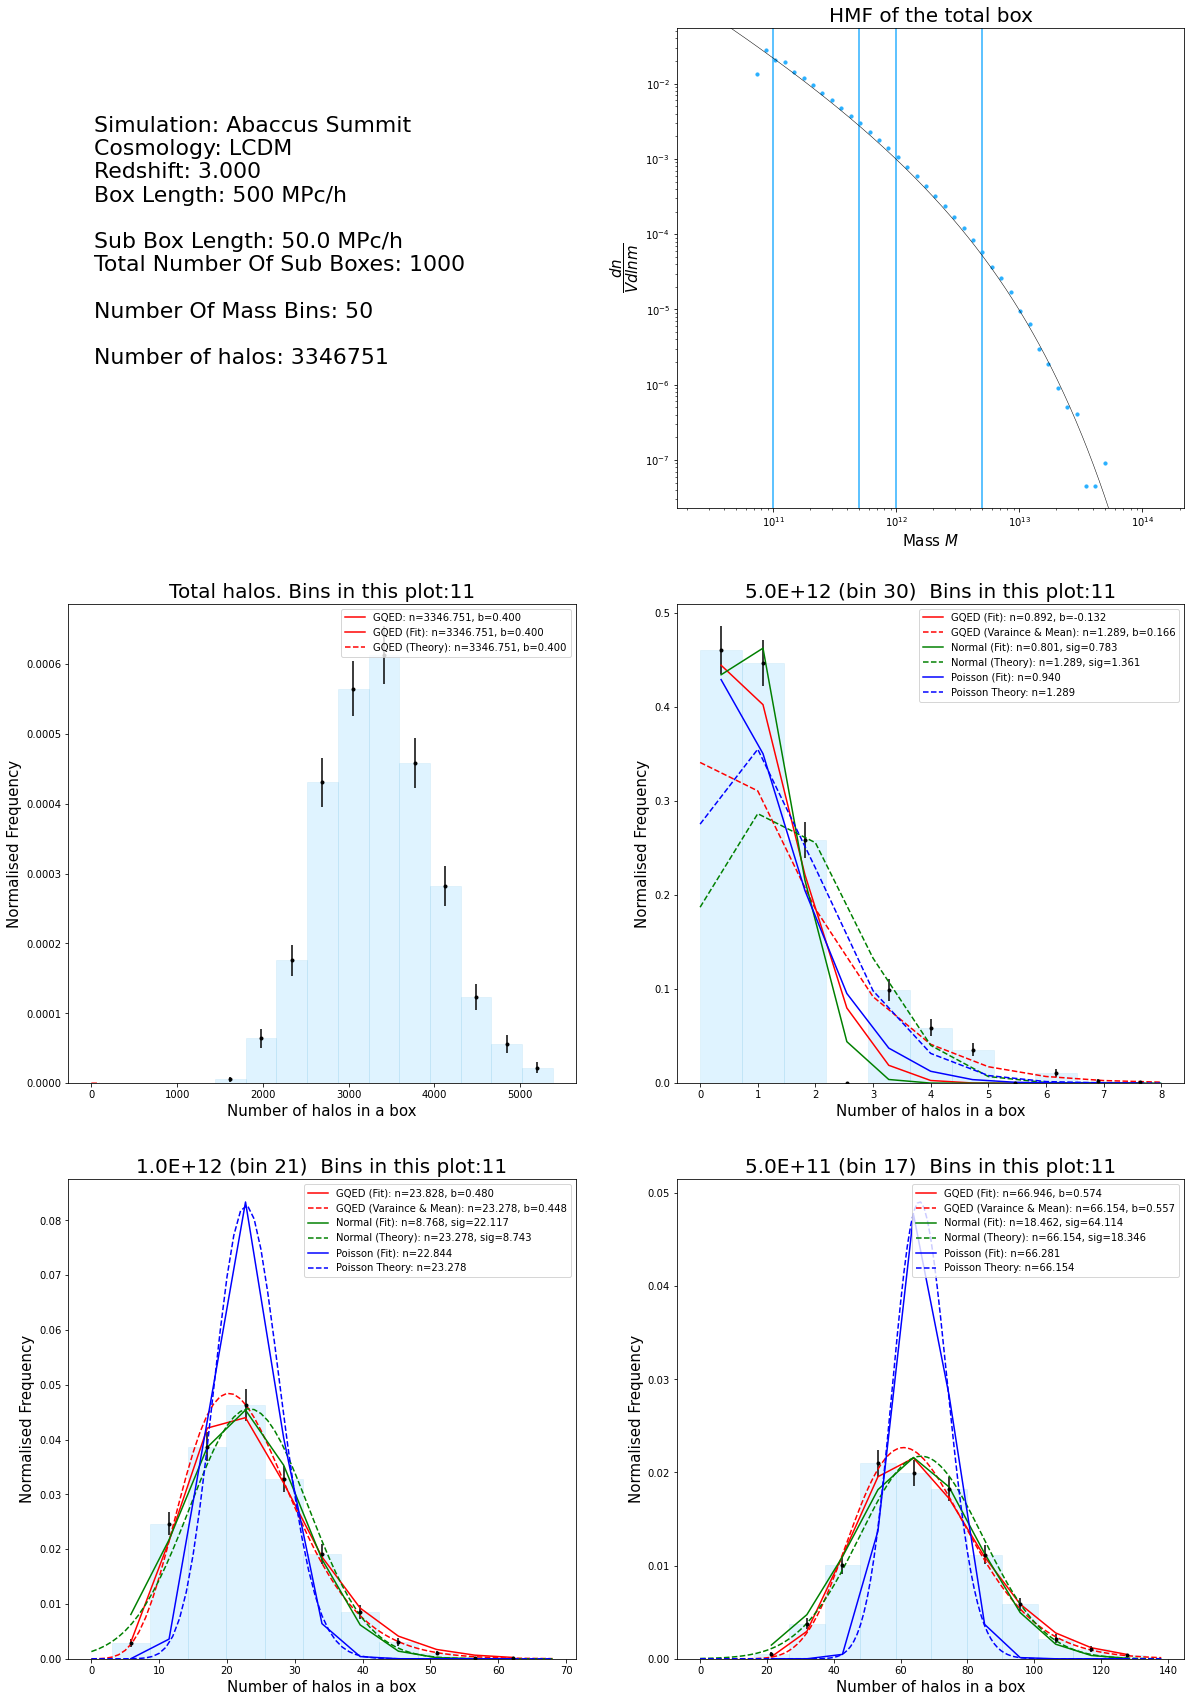

In [15]:
for redshift in redshifts:
   print(redshift)
   directory = os.getcwd()

   pathset = os.path.join(directory,direc,redshift)
   #pathset = os.path.join(directory,direc) #for test cases without reshift

   data = np.load(os.path.join(pathset,filename) + '.npy')
   #pdf = PdfPages('Plots/'+ str(redshift) +'z ' + filename + '.pdf')
   binedge=np.logspace(np.log10(np.min(data[:,0]))-0.5,np.log10(np.max(data[:,0]))+0.5, totalbins+1)
   dm = np.log10(binedge[1])-np.log10(binedge[0])
   #Total HMF
   print("Calculating HMF")
   totalhmf = np.zeros(totalbins)
   for i in data[:,0]:
      f = int((np.log10(i) - np.log10(binedge[0]))/dm)
      totalhmf[f]= totalhmf[f]+1

   totalbin_centers = []
   for i in range (len(binedge)-1):
      totalbin_centers.append(np.sqrt(binedge[i+1]*binedge[i]))

   global binsize 
   binsize = []
   for i in range (len(binedge)-1):
      binsize.append(binedge[i+1]-binedge[i])

   totalhmf_hght = []
   for i in range(len(totalhmf)):              
      totalhmf_hght.append(totalhmf[i]/((binsize[i]/totalbin_centers[i])*totalvolume))

   #nbin_centers, nhmf_hght = nbodyhmf(data[:,0],totalvolume)

   #Total HMF from hmfcalc
   hmf = hmfcalc(redshift)

   for cutside in cutsides:
      cutside = int(cutside)
      totalboxes = cutside**3
      boxvolume = totalvolume/totalboxes
      
      boxes = calcboxes(boxsize, cutside, data[:,1:4])

      #Box halo numbers
      boxdata = np.zeros((totalbins,totalboxes))
      for i in range(len(boxes)):
         f = int((np.log10(data[:,0][i]) - np.log10(binedge[0]))/dm)
         boxdata[f][boxes[i]] = boxdata[f][boxes[i]]+1

      print('Plotting cutside:' + str(cutside))

print('Plotting cutside:' + str(cutside))
#Plotting
fig = plt.figure(figsize=(20,30))
ax = []
ax.append(plt.subplot2grid((3,2),loc=(0,0),rowspan=1,colspan=1))
ax.append(plt.subplot2grid((3,2),loc=(0,1),rowspan=1,colspan=1))
ax.append(plt.subplot2grid((3,2),loc=(1,0),rowspan=1,colspan=1))
ax.append(plt.subplot2grid((3,2),loc=(1,1),rowspan=1,colspan=1))
ax.append(plt.subplot2grid((3,2),loc=(2,0),rowspan=1,colspan=1))
ax.append(plt.subplot2grid((3,2),loc=(2,1),rowspan=1,colspan=1))

#Plot HMF
#ax[1].scatter(nbin_centers, nhmf_hght, color = '#2ab0ff' , s=10)
ax[1].scatter(totalbin_centers, totalhmf_hght, color = '#2ab0ff' , s=10)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].axvline(x=10**11, color='#2ab0ff')
ax[1].axvline(x=5*10**11, color='#2ab0ff')
ax[1].axvline(x=10**12, color='#2ab0ff')
ax[1].axvline(x=5*10**12, color='#2ab0ff')
xmin,xmax = ax[1].get_xlim()
ymin,ymax = ax[1].get_ylim()
ax[1].loglog(hmf.m,hmf.dndlnm, linewidth=0.5, color ='k')
ax[1].set_xlim(xmin,xmax)
ax[1].set_ylim(ymin,ymax)
ax[1].set_title("HMF of the total box", fontsize=20)
ax[1].set_xlabel("Mass $M$", fontsize=15)
ax[1].set_ylabel("$\dfrac{dn}{Vdlnm}$", fontsize=15)


bins = 11

plt_ax = 2

y_valueerr, binedgeserr = np.histogram(np.sum(boxdata, axis=0), bins=bins)
y_value, binedges, patches = ax[2].hist(np.sum(boxdata, axis=0), bins=bins, density=True, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5, alpha = 0.15)
ax[plt_ax].set_title("Total halos. Bins in this plot:"+str(bins), fontsize=20)
#ax[plt_ax].set_title(f"{mass:.1E}" +" (bin " + str(f)+")  Bins in this plot:"+str(bins), fontsize=20)
ax[plt_ax].set_xlabel("Number of halos in a box", fontsize=15)
ax[plt_ax].set_ylabel("Normalised Frequency", fontsize=15)
#print(y_value)
x_value = (0.5*(binedges[1:] + binedges[:-1]))

# y_valuenew = y_valueerr/((binedges[1]-binedges[0])*np.sum(y_valueerr))

errorbar = np.sqrt(y_valueerr)/((binedges[1]-binedges[0])*np.sum(y_valueerr))
# errorbar = np.sqrt(y_value)

ax[plt_ax].errorbar(x_value, y_value, yerr=errorbar, fmt='k.')

# ax[j+3].bar(x_value, y_valuenew, 
#    yerr= errorbar, 
#    color = '#2ab0ff', edgecolor='#169acf', alpha = 0.15)


# ax[plt_ax].plot(x_value,y_value)


popt, pcov = curve_fit(gqed, x_value, y_value, p0=(np.mean(np.sum(boxdata, axis=0)),0.4))
popt2, pcov2 = curve_fit(pois, x_value, y_value, p0=(np.mean(np.sum(boxdata, axis=0)),))
popt3, pcov3 = curve_fit(normfun, x_value, y_value, p0=(np.mean(np.sum(boxdata, axis=0)),np.std(np.sum(boxdata, axis=0))))

xmin, xmax = ax[plt_ax].get_xlim()
xmin=0
x_box_no = np.arange(xmin, xmax)
x_poi_no = np.arange(xmin, xmax)
mean = np.mean(np.sum(boxdata, axis=0))
sd = np.std(np.sum(boxdata, axis=0))

ax[2].plot(x_value, gqed(x_value, *popt), 'r-', label='GQED: n=%5.3f, b=%5.3f' % tuple(popt))
ax[plt_ax].plot(x_value, gqed(x_value, *popt), 'r-', label='GQED (Fit): n=%5.3f, b=%5.3f' % tuple(popt))
ax[plt_ax].plot(x_box_no, gqed(x_box_no, mean, popt[1]), 'r--', label='GQED (Theory): n=%5.3f, b=%5.3f' % (mean,popt[1]))

# ax[plt_ax].plot(x_value, normfun(x_value, *popt3), 'g-', label='Normal (Fit): n=%5.3f, sig=%5.3f' % tuple(popt3))
# ax[plt_ax].plot(x_box_no, norm.pdf(x_box_no, mean, sd), 'g--', label='Normal Theory: n=%5.3f, sig=%5.3f' % (mean, sd))

# ax[plt_ax].plot(x_value, pois(x_value, *popt2), 'b-', label='Poisson (Fit): n=%5.3f' % tuple(popt2))
# ax[plt_ax].plot(x_poi_no, poisson.pmf(x_poi_no, mean), 'b--', label='Poisson Theory: n=%5.3f' %mean )

ax[plt_ax].legend(loc="upper right")

masses= [5*10**12,10**12,5*10**11]
for j, mass in enumerate(masses):

   plt_ax = j+3

   f=int((np.log10(mass) - np.log10(binedge[0]))/dm)

   y_valueerr, binedgeserr = np.histogram(boxdata[f][:], bins=bins)

   y_value, binedges, _ = ax[plt_ax].hist(boxdata[f][:], bins=bins, 
      density=True, 
      facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5, alpha=0.15)
   
   x_value = (0.5*(binedges[1:] + binedges[:-1]))

   # y_valuenew = y_valueerr/((binedges[1]-binedges[0])*np.sum(y_valueerr))

   errorbar = np.sqrt(y_valueerr)/((binedges[1]-binedges[0])*np.sum(y_valueerr))
   # errorbar = np.sqrt(y_value)
   
   ax[plt_ax].errorbar(x_value, y_value, yerr=errorbar, fmt='k.')

   # ax[plt_ax].bar(x_value, y_valuenew, 
   #    yerr= errorbar, 
   #    color = '#2ab0ff', edgecolor='#169acf', alpha = 0.15)

   ax[plt_ax].set_title(f"{mass:.1E}" +" (bin " + str(f)+")  Bins in this plot:"+str(bins), fontsize=20)
   ax[plt_ax].set_xlabel("Number of halos in a box", fontsize=15)
   ax[plt_ax].set_ylabel("Normalised Frequency", fontsize=15)

   #print(y_value)
   #print(x_value)
   #ax[plt_ax].plot(x_value,y_value)
   
   popt, pcov = curve_fit(gqed, x_value, y_value, p0=(np.mean(boxdata[f][:]),0.2))
   popt2, pcov2 = curve_fit(pois, x_value, y_value, p0=(np.mean(boxdata[f][:]),))
   popt3, pcov3 = curve_fit(normfun, x_value, y_value, p0=(np.mean(boxdata[f][:]),np.std(boxdata[f][:])))

   xmin, xmax = ax[plt_ax].get_xlim()
   xmin=0
   x_box_no = np.arange(xmin, xmax)
   x_poi_no = np.arange(xmin, xmax)
   mean = np.mean(boxdata[f][:])
   sd = np.std(boxdata[f][:])

   ax[plt_ax].plot(x_value, gqed(x_value, *popt), 'r-', label='GQED (Fit): n=%5.3f, b=%5.3f' % tuple(popt))

   var_cor_2 = (np.var(boxdata[f][:]) - mean)/mean**2
   b_var = 1 - (mean*var_cor_2+1)**(-1/2)
   ax[plt_ax].plot(x_box_no, gqed(x_box_no, mean, b_var), 'r--', label='GQED (Varaince & Mean): n=%5.3f, b=%5.3f' % (mean,b_var))

   ax[plt_ax].plot(x_value, normfun(x_value, *popt3), 'g-', label='Normal (Fit): n=%5.3f, sig=%5.3f' % tuple(popt3))
   ax[plt_ax].plot(x_box_no, norm.pdf(x_box_no, mean, sd), 'g--', label='Normal (Theory): n=%5.3f, sig=%5.3f' % (mean, sd))

   ax[plt_ax].plot(x_value, pois(x_value, *popt2), 'b-', label='Poisson (Fit): n=%5.3f' % tuple(popt2))
   ax[plt_ax].plot(x_box_no, poisson.pmf(x_poi_no, mean), 'b--', label='Poisson Theory: n=%5.3f' %mean )

   ax[plt_ax].legend(loc="upper right")



ax[0].axis('off')
ax[0].text(0.05, 0.3, 'Simulation: ' + str(simname) +
                     '\nCosmology: LCDM' +
                     '\nRedshift: ' + str(redshift) + 
                     '\nBox Length: ' + str(boxsize) + ' MPc/h' +
                     '\n\nSub Box Length: ' + str(boxsize/cutside) + ' MPc/h' +
                     '\nTotal Number Of Sub Boxes: ' + str(totalboxes) +
                     '\n\nNumber Of Mass Bins: ' + str(totalbins) +
                     '\n\nNumber of halos: ' + str(len(data[:,0]))
                     ,size=22)

# plt.savefig(filename + str(size/cutside) + ".pdf")
# del data, boxdata, totalbin_centers, totalhmf_hght
# pdf.close()

# CIC With GQED Fit

3.000
Calculating HMF
HMF Calc
Divideing boxes: 10
Plotting cutside:10


/tmp/ipykernel_11739/932204459.py:63: RuntimeWarning: overflow encountered in power
  return ((a*(1-b))/gamma(x+1)) * (a*(1-b)+x*b)**(x-1) * np.exp(-a*(1-b)-(x*b))
/home/albinpjames/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


TypeError: _parse_args() takes from 1 to 3 positional arguments but 4 were given

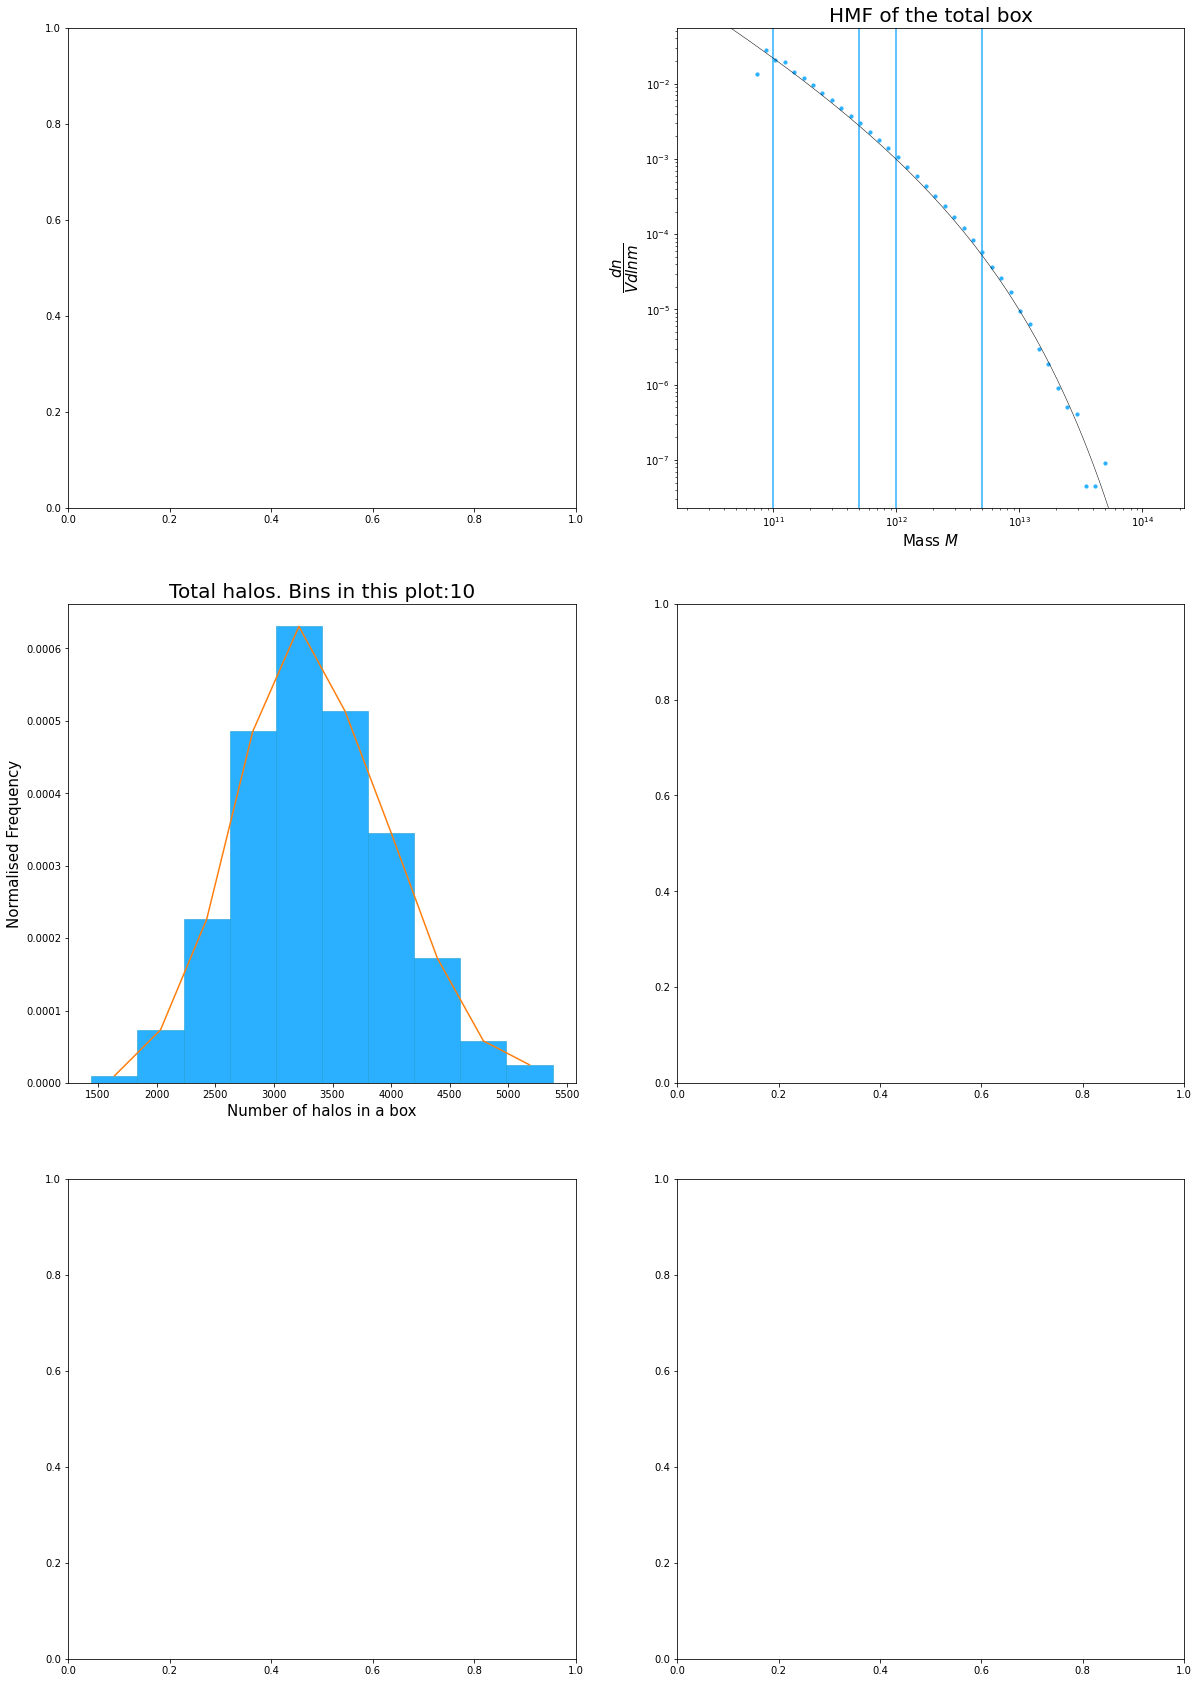

In [17]:
for redshift in redshifts:
   print(redshift)
   directory = os.getcwd()

   pathset = os.path.join(directory,direc,redshift)
   #pathset = os.path.join(directory,direc) #for test cases without reshift

   data = np.load(os.path.join(pathset,filename) + '.npy')
   #pdf = PdfPages('Plots/'+ str(redshift) +'z ' + filename + '.pdf')
   binedge=np.logspace(np.log10(np.min(data[:,0]))-0.5,np.log10(np.max(data[:,0]))+0.5, totalbins+1)
   dm = np.log10(binedge[1])-np.log10(binedge[0])
   #Total HMF
   print("Calculating HMF")
   totalhmf = np.zeros(totalbins)
   for i in data[:,0]:
      f = int((np.log10(i) - np.log10(binedge[0]))/dm)
      totalhmf[f]= totalhmf[f]+1

   totalbin_centers = []
   for i in range (len(binedge)-1):
      totalbin_centers.append(np.sqrt(binedge[i+1]*binedge[i]))

   global binsize 
   binsize = []
   for i in range (len(binedge)-1):
      binsize.append(binedge[i+1]-binedge[i])

   totalhmf_hght = []
   for i in range(len(totalhmf)):              
      totalhmf_hght.append(totalhmf[i]/((binsize[i]/totalbin_centers[i])*totalvolume))

   #nbin_centers, nhmf_hght = nbodyhmf(data[:,0],totalvolume)

   #Total HMF from hmfcalc
   hmf = hmfcalc(redshift)

   for cutside in cutsides:
      cutside = int(cutside)
      totalboxes = cutside**3
      boxvolume = totalvolume/totalboxes
      
      boxes = calcboxes(boxsize, cutside, data[:,1:4])

      #Box halo numbers
      boxdata = np.zeros((totalbins,totalboxes))
      for i in range(len(boxes)):
         f = int((np.log10(data[:,0][i]) - np.log10(binedge[0]))/dm)
         boxdata[f][boxes[i]] = boxdata[f][boxes[i]]+1

      print('Plotting cutside:' + str(cutside))
      #Plotting
      fig = plt.figure(figsize=(20,30))
      ax = []
      ax.append(plt.subplot2grid((3,2),loc=(0,0),rowspan=1,colspan=1))
      ax.append(plt.subplot2grid((3,2),loc=(0,1),rowspan=1,colspan=1))
      ax.append(plt.subplot2grid((3,2),loc=(1,0),rowspan=1,colspan=1))
      ax.append(plt.subplot2grid((3,2),loc=(1,1),rowspan=1,colspan=1))
      ax.append(plt.subplot2grid((3,2),loc=(2,0),rowspan=1,colspan=1))
      ax.append(plt.subplot2grid((3,2),loc=(2,1),rowspan=1,colspan=1))

      #Plot HMF
      #ax[1].scatter(nbin_centers, nhmf_hght, color = '#2ab0ff' , s=10)
      ax[1].scatter(totalbin_centers, totalhmf_hght, color = '#2ab0ff' , s=10)
      ax[1].set_xscale('log')
      ax[1].set_yscale('log')
      ax[1].axvline(x=10**11, color='#2ab0ff')
      ax[1].axvline(x=5*10**11, color='#2ab0ff')
      ax[1].axvline(x=10**12, color='#2ab0ff')
      ax[1].axvline(x=5*10**12, color='#2ab0ff')
      xmin,xmax = ax[1].get_xlim()
      ymin,ymax = ax[1].get_ylim()
      ax[1].loglog(hmf.m,hmf.dndlnm, linewidth=0.5, color ='k')
      ax[1].set_xlim(xmin,xmax)
      ax[1].set_ylim(ymin,ymax)
      ax[1].set_title("HMF of the total box", fontsize=20)
      ax[1].set_xlabel("Mass $M$", fontsize=15)
      ax[1].set_ylabel("$\dfrac{dn}{Vdlnm}$", fontsize=15)


      bins = 10
      y_value, binedges, patches = ax[2].hist(np.sum(boxdata, axis=0), bins=bins, density= True, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
      ax[2].set_title("Total halos. Bins in this plot:"+str(bins), fontsize=20)
      #ax[2].set_title(f"{mass:.1E}" +" (bin " + str(f)+")  Bins in this plot:"+str(bins), fontsize=20)
      ax[2].set_xlabel("Number of halos in a box", fontsize=15)
      ax[2].set_ylabel("Normalised Frequency", fontsize=15)
      #print(y_value)
      x_value = (0.5*(binedges[1:] + binedges[:-1]))
      #print(x_value)
      
      
      ax[2].plot(x_value,y_value)
      

      popt, pcov = curve_fit(gqed, x_value, y_value, p0=(np.mean(np.sum(boxdata, axis=0)),0.4))
      popt2, pcov2 = curve_fit(pois, x_value, y_value, p0=(np.mean(np.sum(boxdata, axis=0)),))
      popt3, pcov3 = curve_fit(norm, x_value, y_value, p0=(np.mean(np.sum(boxdata, axis=0)),np.std(np.sum(boxdata, axis=0))))
   
      ax[2].plot(x_value, gqed(x_value, *popt), 'r-', label='GQED: n=%5.3f, b=%5.3f' % tuple(popt))
      ax[2].plot(x_value, pois(x_value, *popt2), 'b-', label='Poisson: n=%5.3f' % tuple(popt2))
      ax[2].plot(x_value, norm(x_value, *popt3), 'g--', label='Normal: n=%5.3f, sig=%5.3f' % tuple(popt3))



      # xmin, xmax = ax[2].get_xlim()
      # xmin=0
      # x_box_no = np.arange(xmin, xmax, 0.01)
      # x_poi_no = np.arange(xmin, xmax)
      # mean = np.mean(np.sum(boxdata, axis=0))
      # sd = np.std(np.sum(boxdata, axis=0))
      # ax[2].plot(x_box_no, norm.pdf(x_box_no, mean, sd), 'k--', label='Gaussian')
      # ax[2].plot(x_poi_no, poisson.pmf(x_poi_no, mean), 'k', label='Poisson' )
      ax[2].legend(loc="upper right")
      
      masses= [5*10**12,10**12,5*10**11]
      for j, mass in enumerate(masses):
         f=int((np.log10(mass) - np.log10(binedge[0]))/dm)

         y_value, binedges, _ = ax[j+3].hist(boxdata[f][:], bins=bins, density= True,facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
         x_value = (0.5*(binedges[1:] + binedges[:-1]))
         ax[j+3].set_title(f"{mass:.1E}" +" (bin " + str(f)+")  Bins in this plot:"+str(bins), fontsize=20)
         ax[j+3].set_xlabel("Number of halos in a box", fontsize=15)
         ax[j+3].set_ylabel("Normalised Frequency", fontsize=15)

         #print(y_value)
         
         #print(x_value)
         
        
         #ax[j+3].plot(x_value,y_value)
         
      
         popt, pcov = curve_fit(gqed, x_value, y_value, p0=(np.mean(boxdata[f][:]),0.4))
         popt2, pcov2 = curve_fit(pois, x_value, y_value, p0=(np.mean(boxdata[f][:]),))
         popt3, pcov3 = curve_fit(norm, x_value, y_value, p0=(np.mean(boxdata[f][:]),np.std(boxdata[f][:])))

      
         ax[j+3].plot(x_value, gqed(x_value, *popt), 'r-', label='GQED: n=%5.3f, b=%5.3f' % tuple(popt))
         ax[j+3].plot(x_value, pois(x_value, *popt2), 'b-', label='Poisson: n=%5.3f' % tuple(popt2))
         ax[j+3].plot(x_value, norm(x_value, *popt3), 'g--', label='Normal: n=%5.3f, sig=%5.3f' % tuple(popt3))


         
         #label='fit: n=%5.3f, b=%5.3f' % tuple(popt))

         # xmin, xmax = ax[j].get_xlim()
         # xmin=0
         # x_box_no = np.arange(xmin, xmax, 0.01)
         # x_poi_no = np.arange(xmin, xmax)
         # mean = np.mean(boxdata[f][:])
         # sd = np.std(boxdata[f][:])
         # ax[j].plot(x_box_no, norm.pdf(x_box_no, mean, sd), 'k--', label='Gaussian')
         # ax[j].plot(x_poi_no, poisson.pmf(x_poi_no, mean), 'k', label='Poisson' )
         ax[j+3].legend(loc="upper right")
   

      
      ax[0].axis('off')
      ax[0].text(0.05, 0.3, 'Simulation: ' + str(simname) +
                           '\nCosmology: LCDM' +
                           '\nRedshift: ' + str(redshift) + 
                           '\nBox Length: ' + str(boxsize) + ' MPc/h' +
                           '\n\nSub Box Length: ' + str(boxsize/cutside) + ' MPc/h' +
                           '\nTotal Number Of Sub Boxes: ' + str(totalboxes) +
                           '\n\nNumber Of Mass Bins: ' + str(totalbins) +
                           '\n\nNumber of halos: ' + str(len(data[:,0]))
                           ,size=22)

      #plt.savefig(filename + str(size/cutside) + ".pdf")
   del data, boxdata, totalbin_centers, totalhmf_hght
   #pdf.close()

# CIC MSc Code


3.000
Calculating HMF
HMF Calc
Divideing boxes: 10
Plotting cutside:10


AttributeError: 'function' object has no attribute 'pdf'

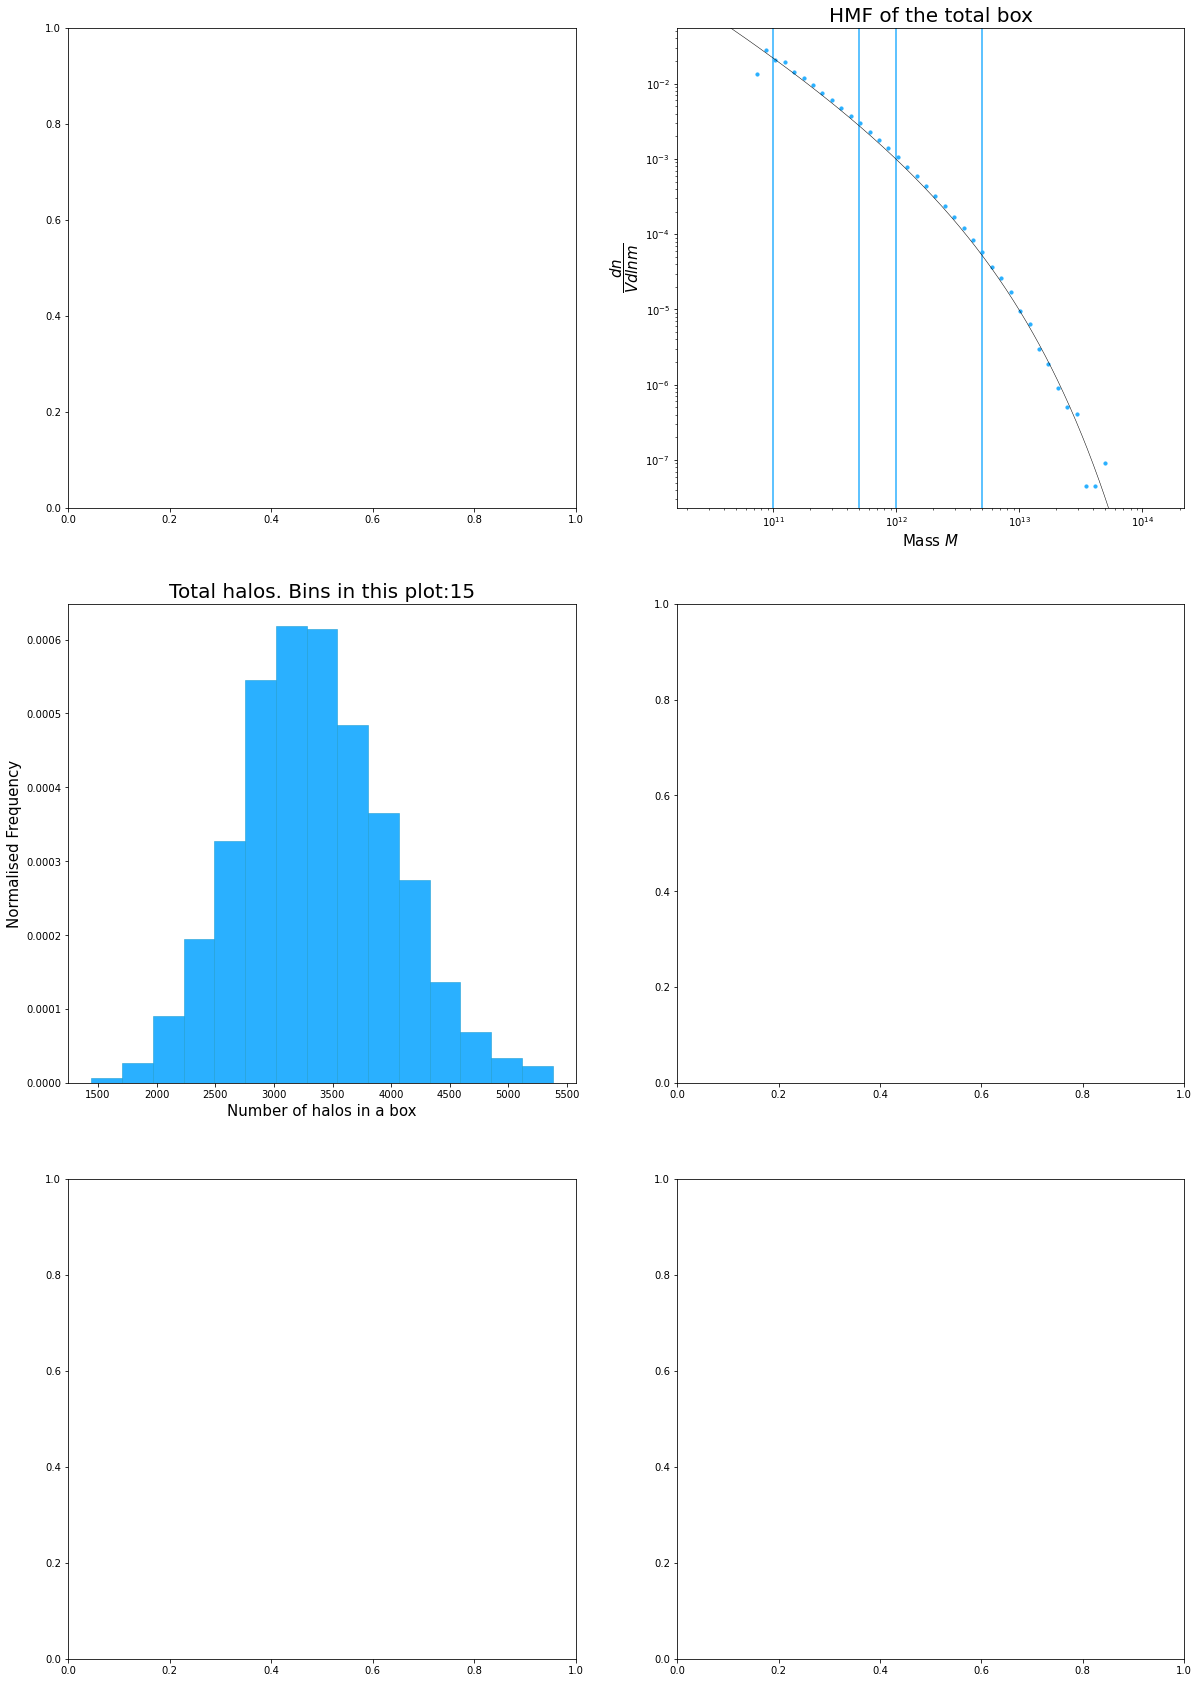

In [7]:
for redshift in redshifts:
   print(redshift)
   directory = os.getcwd()

   pathset = os.path.join(directory,direc,redshift)
   #pathset = os.path.join(directory,direc) #for test cases without reshift

   data = np.load(os.path.join(pathset,filename) + '.npy')
   #pdf = PdfPages('Plots/'+ str(redshift) +'z ' + filename + '.pdf')
   binedge=np.logspace(np.log10(np.min(data[:,0]))-0.5,np.log10(np.max(data[:,0]))+0.5, totalbins+1)
   dm = np.log10(binedge[1])-np.log10(binedge[0])
   #Total HMF
   print("Calculating HMF")
   totalhmf = np.zeros(totalbins)
   for i in data[:,0]:
      f = int((np.log10(i) - np.log10(binedge[0]))/dm)
      totalhmf[f]= totalhmf[f]+1

   totalbin_centers = []
   for i in range (len(binedge)-1):
      totalbin_centers.append(np.sqrt(binedge[i+1]*binedge[i]))

   global binsize 
   binsize = []
   for i in range (len(binedge)-1):
      binsize.append(binedge[i+1]-binedge[i])

   totalhmf_hght = []
   for i in range(len(totalhmf)):              
      totalhmf_hght.append(totalhmf[i]/((binsize[i]/totalbin_centers[i])*totalvolume))

   #nbin_centers, nhmf_hght = nbodyhmf(data[:,0],totalvolume)

   #Total HMF from hmfcalc
   hmf = hmfcalc(redshift)

   for cutside in cutsides:
      cutside = int(cutside)
      totalboxes = cutside**3
      boxvolume = totalvolume/totalboxes
      
      boxes = calcboxes(boxsize, cutside, data[:,1:4])

      #Box halo numbers
      boxdata = np.zeros((totalbins,totalboxes))
      for i in range(len(boxes)):
         f = int((np.log10(data[:,0][i]) - np.log10(binedge[0]))/dm)
         boxdata[f][boxes[i]] = boxdata[f][boxes[i]]+1

      print('Plotting cutside:' + str(cutside))
      #Plotting
      fig = plt.figure(figsize=(20,30))
      ax = []
      ax.append(plt.subplot2grid((3,2),loc=(0,0),rowspan=1,colspan=1))
      ax.append(plt.subplot2grid((3,2),loc=(0,1),rowspan=1,colspan=1))
      ax.append(plt.subplot2grid((3,2),loc=(1,0),rowspan=1,colspan=1))
      ax.append(plt.subplot2grid((3,2),loc=(1,1),rowspan=1,colspan=1))
      ax.append(plt.subplot2grid((3,2),loc=(2,0),rowspan=1,colspan=1))
      ax.append(plt.subplot2grid((3,2),loc=(2,1),rowspan=1,colspan=1))

      #Plot HMF
      #ax[1].scatter(nbin_centers, nhmf_hght, color = '#2ab0ff' , s=10)
      ax[1].scatter(totalbin_centers, totalhmf_hght, color = '#2ab0ff' , s=10)
      ax[1].set_xscale('log')
      ax[1].set_yscale('log')
      ax[1].axvline(x=10**11, color='#2ab0ff')
      ax[1].axvline(x=5*10**11, color='#2ab0ff')
      ax[1].axvline(x=10**12, color='#2ab0ff')
      ax[1].axvline(x=5*10**12, color='#2ab0ff')
      xmin,xmax = ax[1].get_xlim()
      ymin,ymax = ax[1].get_ylim()
      ax[1].loglog(hmf.m,hmf.dndlnm, linewidth=0.5, color ='k')
      ax[1].set_xlim(xmin,xmax)
      ax[1].set_ylim(ymin,ymax)
      ax[1].set_title("HMF of the total box", fontsize=20)
      ax[1].set_xlabel("Mass $M$", fontsize=15)
      ax[1].set_ylabel("$\dfrac{dn}{Vdlnm}$", fontsize=15)


      bins = 15   
      ax[2].hist(np.sum(boxdata, axis=0), bins=bins, density= True, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
      ax[2].set_title("Total halos. Bins in this plot:"+str(bins), fontsize=20)
      #ax[2].set_title(f"{mass:.1E}" +" (bin " + str(f)+")  Bins in this plot:"+str(bins), fontsize=20)
      ax[2].set_xlabel("Number of halos in a box", fontsize=15)
      ax[2].set_ylabel("Normalised Frequency", fontsize=15)

      xmin, xmax = ax[2].get_xlim()
      xmin=0
      x_box_no = np.arange(xmin, xmax, 0.01)
      x_poi_no = np.arange(xmin, xmax)
      mean = np.mean(np.sum(boxdata, axis=0))
      sd = np.std(np.sum(boxdata, axis=0))
      ax[2].plot(x_box_no, norm.pdf(x_box_no, mean, sd), 'k--', label='Gaussian')
      ax[2].plot(x_poi_no, poisson.pmf(x_poi_no, mean), 'k', label='Poisson' )
      ax[2].legend(loc="upper right")
      
      masses= [10**11,10**12,5*10**12]
      for j, mass in enumerate(masses):

         f=int((np.log10(mass) - np.log10(binedge[0]))/dm)
         ax[j+3].hist(boxdata[f][:], bins=bins, density= True, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
         ax[j+3].set_title(f"{mass:.1E}" +" (bin " + str(f)+")  Bins in this plot:"+str(bins), fontsize=20)
         ax[j+3].set_xlabel("Number of halos in a box", fontsize=15)
         ax[j+3].set_ylabel("Normalised Frequency", fontsize=15)

         #print(y_value)
         #x_value = (0.5*(bins[1:] + bins[:-1]))
         #print(x_value)
         
        
         #ax[j+3].plot(x_value,y_value)
         #popt, pcov = curve_fit(GQED, x_value, y_value)

         #ax[j+3].plot(x_value, GQED(x_value, *popt), 'r-',
         #label='fit: n=%5.3f, b=%5.3f' % tuple(popt))

         xmin, xmax = ax[j+3].get_xlim()
         xmin=0
         x_box_no = np.arange(xmin, xmax, 0.01)
         x_poi_no = np.arange(xmin, xmax)
         mean = np.mean(boxdata[f][:])
         sd = np.std(boxdata[f][:])
         ax[j+3].plot(x_box_no, norm.pdf(x_box_no, mean, sd), 'k--', label='Gaussian')
         ax[j+3].plot(x_poi_no, poisson.pmf(x_poi_no, mean), 'k', label='Poisson' )
         ax[j+3].legend(loc="upper right")

      
      ax[0].axis('off')
      ax[0].text(0.05, 0.3, 'Simulation: ' + str(simname) +
                           '\nCosmology: LCDM' +
                           '\nRedshift: ' + str(redshift) + 
                           '\nBox Length: ' + str(boxsize) + ' MPc/h' +
                           '\n\nSub Box Length: ' + str(boxsize/cutside) + ' MPc/h' +
                           '\nTotal Number Of Sub Boxes: ' + str(totalboxes) +
                           '\n\nNumber Of Mass Bins: ' + str(totalbins) +
                           '\n\nNumber of halos: ' + str(len(data[:,0]))
                           ,size=22)

      #plt.savefig(filename + str(size/cutside) + ".pdf")
   del data, boxdata, totalbin_centers, totalhmf_hght
   #pdf.close()